## Import and misc

In [1]:
# Instal latest torch and torchaudio

In [71]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm.notebook import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_


In [3]:
!pip install wandb --q

import wandb
wandb.login()

wandb: Currently logged in as: dlishudi. Use `wandb login --relogin` to force relogin


True

In [72]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    # added those constants to config ------------------------------------------
    # coefs for layer distillation; needed to normalize MSE compared to CE loss
    conv_normalizer: float = 10
    gru_normalizer: float = 1
    # projection optimizer LR
    proj_lr: float = 1e-3
    # win_length and hop_length are used for stream bufferization
    n_fft: int = 400
    win_length: int = 400
    hop_length: int = 160
    # maximum time length of buffer AFTER convolution
    max_buffer_length: int = 3 * 100 // 8  
    # 3 * 100 * 160 samples <--> 3 seconds of real time
    # divide by 8 cause of kernel stride

In [88]:
!pip install thop
from thop import profile 
import tempfile
from copy import deepcopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [97]:
def calc_macs(model):
    noise = (torch.rand(1, 16000 * 2) * 2 - 1).to(TaskConfig.device)
    noise = melspec_val(noise).to(model.cur_type)
    macs, aprams = profile(deepcopy(model), (noise, ), verbose=False)
    return macs

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

# Seminar

## Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

## Data

In [7]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2022-11-06 22:02:10--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.119.128, 2a00:1450:4013:c00::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.119.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   126MB/s    in 7.8s    

2022-11-06 22:02:18 (182 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

mkdir: cannot create directory ‘speech_commands’: File exists


In [8]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [9]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [10]:
dataset.csv.sample(5)

,path,keyword,label
16803,speech_commands/four/28ce0c58_nohash_5.wav,four,0
63927,speech_commands/zero/bf90a57a_nohash_0.wav,zero,0
21874,speech_commands/one/eb0676ec_nohash_1.wav,one,0
29510,speech_commands/nine/f19c1390_nohash_0.wav,nine,0
29047,speech_commands/nine/dff327c5_nohash_2.wav,nine,0


### Augmentations

In [11]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [12]:
# Added seed fix

gen = torch.Generator()
gen.manual_seed(0)

indexes = torch.randperm(len(dataset), generator=gen)
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [13]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

In [14]:
train_set.csv

,path,keyword,label
0,speech_commands/six/7cf14c54_nohash_0.wav,six,0
1,speech_commands/left/df1d5024_nohash_1.wav,left,0
2,speech_commands/one/ae82c78c_nohash_1.wav,one,0
3,speech_commands/wow/6940f7f3_nohash_1.wav,wow,0
4,speech_commands/down/73af0c50_nohash_0.wav,down,0
...,...,...,...
51771,speech_commands/house/73124b26_nohash_0.wav,house,0
51772,speech_commands/go/8281a2a8_nohash_2.wav,go,0
51773,speech_commands/happy/14775481_nohash_0.wav,happy,0
51774,speech_commands/bed/e4a2cf79_nohash_0.wav,bed,0


### Sampler for oversampling:

In [15]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [16]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [17]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [18]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [19]:
class LogMelspec:
    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=config.n_fft,
                    win_length=config.win_length,
                    hop_length=config.hop_length,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=config.n_fft,
                win_length=config.win_length,
                hop_length=config.hop_length,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [20]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [21]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [22]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

## Model

In [111]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        # used for layer distillation
        self.conv_out_size = self.conv_out_frequency * config.cnn_out_channels
        self.hidden_size = config.hidden_size
        self.cur_type = torch.float32

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)


    def change_type(self, dtype):
      self.cur_type = dtype
      self.to(dtype)


    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

    def forward_features(self, input):
        # used for layer distillation
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        # used for layer distillation
        return conv_output, gru_output, output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [24]:
def train_epoch(model, opt, scheduler, loader, log_melspec, device, logger=wandb):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # with torch.autocast(device.type):
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        if scheduler is not None:
            scheduler.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)
        
        if logger is not None:
            cur_logs = {
                'train loss' : loss.cpu().item(),
                'train acc' : acc,
                'train FA'  : FA,
                'train FR'  : FR,
            }
            if scheduler is not None:
                cur_logs['learning rate'] = scheduler.get_last_lr()[0]
            logger.log(cur_logs)

    return acc

In [105]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch).to(model.cur_type)

        # with torch.autocast(device.type):
        output = model(batch).to(float)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    
    return au_fa_fr, np.mean(val_losses), np.mean(accs), np.mean(FAs), np.mean(FRs)

In [26]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

## Training

In [27]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

In [28]:
# TRAIN

def simple_train(model, opt, scheduler, train_loader, val_loader,
                 melspec_train, melspec_val, config
    ):
    history = defaultdict(list)
    for n in range(config.num_epochs):
        train_epoch(model, opt, scheduler, train_loader,
                    melspec_train, config.device)

        au_fa_fr, loss, acc, FA, FR = validation(model, val_loader,
                            melspec_val, config.device)

        cur_logs = {
            'valid AU_FA_FR'  : au_fa_fr,
            'valid mean loss' : loss,
            'valid mean acc'  : acc,
            'valid mean FA'   : FA,
            'valid mean FR'   : FR,
            'epoch' : n+1
        }
        wandb.log(cur_logs)

        history['val_metric'].append(au_fa_fr)

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

        print('END OF EPOCH', n)
    return history

In [29]:
# config = TaskConfig(hidden_size=32)
# SEED = 0
# set_random_seed(SEED)
# model = CRNN(config).to(config.device)

# print(model)

# opt = torch.optim.Adam(
#     model.parameters(),
#     lr=config.learning_rate,
#     weight_decay=config.weight_decay
# )

# scheduler = None

# wandb.init(
#     project='DLA-KWS',
#     config={
#     'architecture': 'base_model',
#     **dataclasses.asdict(config)
# })
# history = simple_train(model, opt, scheduler, train_loader, val_loader,
#        melspec_train, melspec_val, config
# )
# history

In [30]:
# torch.save(model.state_dict(), 'base_model.pth')

### Reproduce

In [31]:
# history = defaultdict(list)
# SEED = 0
# set_random_seed(SEED)
# config = TaskConfig(hidden_size=32)
# model = CRNN(config).to(config.device)

# print(model)

# opt = torch.optim.Adam(
#     model.parameters(),
#     lr=config.learning_rate,
#     weight_decay=config.weight_decay
# )

In [32]:
# # TRAIN

# for n in range(TaskConfig.num_epochs):
#     train_epoch(model, opt, train_loader, 
#                 melspec_train, config.device)

#     au_fa_fr = validation(model, val_loader,
#                           melspec_val, config.device)
#     history['val_metric'].append(au_fa_fr)

#     clear_output()
#     plt.plot(history['val_metric'])
#     plt.ylabel('Metric')
#     plt.xlabel('Epoch')
#     plt.grid()
#     plt.show()

#     print('END OF EPOCH', n)

In [33]:
# history

# HW

## Streaming

### Model

Streaming is implemented for original model, but it'll work the same with compact model due to the same topology.

In [112]:
class StreamingCRNN(nn.Module):
    def __init__(self, config: TaskConfig, streaming_step_size: int = 1):
        super().__init__()
        self.offline_model = CRNN(config)

        self.max_buf_size = config.max_buffer_length
        self.step_size = streaming_step_size

        # we need 3 buffers:

        # audio window buffer for melspec (shifting windows in STFT)
        self.audio_buf_size = config.win_length - config.hop_length
        self.register_buffer(
            'audio_buffer',
            torch.zeros(self.audio_buf_size),
            persistent=False
        )

        # melspec frames buffer for convolution
        self.time_kernel_size = config.kernel_size[1]
        # CNN is similar to STFT; kernel_size is win_length; stride is hop_size
        self.cnn_buf_size = config.kernel_size[1] - config.stride[1] 
        self.register_buffer(
            'cnn_buffer',
            torch.zeros(1, 1, config.n_mels, self.cnn_buf_size),
            persistent=False
        )
        self.cur_num_frames = 0

        # GRU output buffer
        self.register_buffer(
            'gru_buffer',
            torch.zeros(self.max_buf_size, config.hidden_size),
            persistent=False
        )
        self.cur_buf_size = 0
    
        # last hidden layer of GRU
        self.last_hidden = torch.zeros(config.gru_num_layers, config.hidden_size)

        # we need to make config.stride[1] melspec columns for 1 conv output feature vector
        self.frame_step_size = streaming_step_size * config.stride[1]
        self.chunk_size = self.frame_step_size * config.hop_length
        self.n_mels = config.n_mels

        self.melspec = torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=config.n_fft,
                    win_length=config.win_length,
                    hop_length=config.hop_length,
                    n_mels=config.n_mels,
                    center=False
        )


    def forward(self, input, preprocess=True):
        # preprocess (melspectrogram) ==========================================

        if preprocess:
            assert len(input) == self.chunk_size,\
                f'chunk size equals {len(input)}, should be {self.chunk_size} instead'

            audio = torch.cat((self.audio_buffer, input), dim=0)
            self.audio_buffer = audio[-self.audio_buf_size:]
            input = torch.log(self.melspec(audio).clamp_(min=1e-9, max=1e9))

        # convolution ==========================================================

        assert input.shape[0] == self.n_mels,\
            f'input has {input.shape[0]} melspec rows, should be {self.n_mels} instead'
        assert input.shape[1] == self.frame_step_size,\
            f'input has {input.shape[1]} melspec columns, should be {self.frame_step_size} instead'

        frames = torch.cat((self.cnn_buffer, input[None,None,:,:]), dim=-1)
        self.cnn_buffer = frames[:,:,:,-self.cnn_buf_size:]

        # we need to collect self.time_kernel_size frames to start
        self.cur_num_frames = min(
            self.cur_num_frames + self.frame_step_size,
            self.time_kernel_size
        )
        if self.cur_num_frames < self.time_kernel_size:
            return 0 # not enough frames
        conv_output = self.offline_model.conv(frames).transpose(-1, -2)[0]

        # GRU ==================================================================

        cur_gru_out, self.last_hidden = self.offline_model.gru(conv_output, self.last_hidden)

        gru_out = torch.cat((self.gru_buffer[:self.cur_buf_size], cur_gru_out), dim=-2)
        self.cur_buf_size = min(self.cur_buf_size + self.step_size, self.max_buf_size)
        if self.cur_buf_size < self.max_buf_size:
            self.gru_buffer[self.cur_buf_size-self.step_size : self.cur_buf_size] = cur_gru_out
        else:
            self.gru_buffer = gru_out[-self.max_buf_size:]

        # head =================================================================

        contex_vector = self.offline_model.attention(gru_out)
        output = self.offline_model.classifier(contex_vector)
        return output.softmax(dim=0)[1].item()

In [113]:
# creating model

config = TaskConfig(hidden_size=32)
# config = finalconfig
step_size = 3
stream_model = StreamingCRNN(config, step_size)
stream_model.offline_model.load_state_dict(torch.load('base_model.pth'))

# saving model

model_scripted = torch.jit.script(stream_model)
model_scripted.save('streaming_model.pth')

# checking saved script

# print(*model_scripted.code.split('\n'), sep='\n')

# loading model

loaded_streaming_model = torch.jit.load('streaming_model.pth')

### Testing on stitched audio

#### Creating audio

We'll stitch together different tracks to show how streaming works. Audio will be organised as follows:
* 10 wrong words
* 1 correct keyword
* 20 wrong keywords

In [114]:
val_df[val_df.label==0].iloc[16]

path       speech_commands/three/f292725f_nohash_1.wav
keyword                                          three
label                                                0
Name: 16, dtype: object

In [115]:
base_model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

In [116]:
wrong_track_paths = val_df[val_df.label==0].path.to_list()
keyword_track_paths = val_df[val_df.label==1].path.to_list()

# 10 wrong words, correct keyword, 20 incorrect words

left_tracks_num = 10
right_tracks_num = 20

left_paths = wrong_track_paths[:left_tracks_num]
keyword_path = keyword_track_paths[0]
right_paths = wrong_track_paths[-right_tracks_num:]

track_paths = left_paths + [keyword_path] + right_paths

In [117]:
audios = [torchaudio.load(track_path)[0].squeeze() for track_path in track_paths]

stitched_audio = torch.cat(audios, dim=0)
display_.Audio(stitched_audio, rate=config.sample_rate)

In [118]:
# find samples no. in which keyword starts and ends
keyword_start = 0
keyword_end = 0

for i in range(left_tracks_num):
    keyword_start += len(audios[i])

keyword_end = keyword_start + len(audios[left_tracks_num])

#### Testing Streaming

In [119]:
loaded_streaming_model = torch.jit.load('streaming_model.pth').eval()
probas = []

chunk_size = loaded_streaming_model.chunk_size

chunk_start = 0
chunk_end = chunk_start + chunk_size
while chunk_end < len(stitched_audio):
    chunk = stitched_audio[chunk_start:chunk_end]
    probas.append(loaded_streaming_model(chunk))
    chunk_start += chunk_size
    chunk_end   += chunk_size

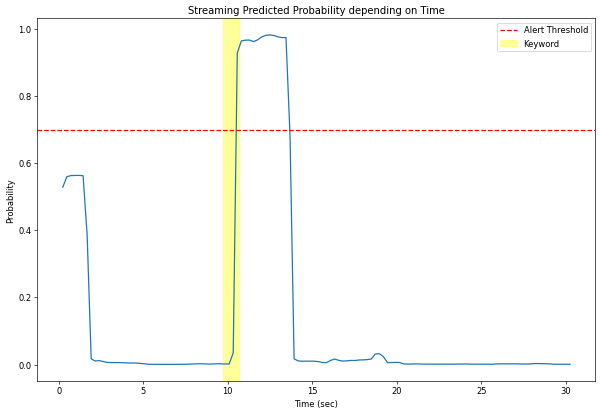

In [120]:
plt.figure(figsize=(12, 8), dpi=60)

sr = config.sample_rate

plt.plot(np.arange(chunk_size, len(stitched_audio), chunk_size) / sr, probas)
plt.axvspan(keyword_start / sr, keyword_end / sr, alpha=0.4, color='yellow', label='Keyword')
plt.axhline(0.7, color='red', linestyle='--', label='Alert Threshold')

plt.xlabel('Time (sec)')
plt.ylabel('Probability')
plt.title('Streaming Predicted Probability depending on Time')
plt.legend();
plt.savefig('5sec_streaming.pdf')

Note, that width of column after keyword spotting corresponds to chosen GRU buffer (approx 3 seconds).

## Speed up & Compression

In [56]:
results = {}

### Dark knowledge distillation

In [46]:
METRIC_THRESHOLD = 1.1 * 5e-5

def train_distillation_epoch(
        model, teacher, opt, scheduler, loader, log_melspec, config,
        distil_coef=0.5, conv_coef=0.25, gru_coef=0.25, temperature=1,
        conv_proj=None, conv_proj_opt=None, gru_proj=None, gru_proj_opt=None,
        logger=wandb
    ):
    '''

      !WARNING!: layer distillation only works if kernel and stride are not changed for time dimension
    '''
    device = config.device

    model.train()
    teacher.eval()
    distil_losses = []

    label_coef = 1 - distil_coef - conv_coef - gru_coef


    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        # zero grad ============================================================

        opt.zero_grad()
        if conv_proj_opt is not None:
          conv_proj_opt.zero_grad()
        if gru_proj_opt is not None:
          conv_proj_opt.zero_grad()

        # run student and teacher ==============================================

        # with torch.autocast(device.type):
        conv, gru, logits = model.forward_features(batch)
        with torch.no_grad():
            teacher_conv, teacher_gru, teacher_out = teacher.forward_features(batch)
            teacher_probs = F.softmax(teacher_out / temperature, dim=-1)


        # we need probabilities so we use softmax & CE separately
        label_loss  = F.cross_entropy(logits, labels)
        distil_loss = F.cross_entropy(logits / temperature, teacher_probs)

        # project student features and calc losses =============================

        if conv_proj is not None:
          conv_loss = F.mse_loss(
              conv_proj(conv).flatten(1), teacher_conv.flatten(1)
          ) / config.conv_normalizer
        else:
          conv_loss = torch.zeros(1).to(device)
        if gru_proj is not None:
          gru_loss  = F.mse_loss(
              gru_proj(gru).flatten(1), teacher_gru.flatten(1)
          ) / config.gru_normalizer
        else:
          gru_loss = torch.zeros(1).to(device)
        
        # final loss ===========================================================

        loss = label_coef * label_loss +\
               distil_coef * distil_coef +\
               conv_coef * conv_loss +\
               gru_coef * gru_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        # opt step =============================================================
      
        opt.step()
        if conv_proj_opt is not None:
          conv_proj_opt.step()
        if gru_proj_opt is not None:
          gru_proj_opt.step()

        if scheduler is not None:
            scheduler.step()

        # logging ==============================================================
        probs = F.softmax(logits, dim=-1)
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)
        
        if logger is not None:
            cur_logs = {
                'train loss' : loss.cpu().item(),
                'train distil label loss' : distil_loss.cpu().item(),
                'train conv feature loss' : conv_loss.cpu().item(),
                'train gru feature loss' : gru_loss.cpu().item(),
                'train true label loss'  : label_loss.cpu().item(),
                'train acc' : acc,
                'train FA'  : FA,
                'train FR'  : FR,
            }
            if scheduler is not None:
                cur_logs['learning rate'] = scheduler.get_last_lr()[0]
            logger.log(cur_logs)
        distil_losses.append(distil_loss.item)

    return acc, distil_loss


def distillation_train(
        model, teacher, opt, scheduler,
        train_loader, val_loader, melspec_train, melspec_val, config,
        distil_coef=0.7, conv_coef=0.1, gru_coef=0.1, temperature=1
    ):
    history = defaultdict(list)
    conv_proj = None
    conv_proj_opt = None
    gru_proj = None
    gru_proj_opt = None
  
    if conv_coef != 0:
      conv_proj = nn.Linear(model.conv_out_size, teacher.conv_out_size).to(config.device)
      conv_proj_opt = torch.optim.Adam(conv_proj.parameters(), lr=config.proj_lr)
    if gru_coef != 0:
      gru_proj  = nn.Linear(model.hidden_size , teacher.hidden_size).to(config.device)
      gru_proj_opt = torch.optim.Adam(gru_proj.parameters(), lr=config.proj_lr)

    for n in range(config.num_epochs):
        train_distillation_epoch(
                model, teacher, opt, scheduler, train_loader, melspec_train, config,
                distil_coef, conv_coef, gru_coef, temperature,
                conv_proj, conv_proj_opt, gru_proj, gru_proj_opt,
        )

        au_fa_fr, loss, acc, FA, FR = validation(
                model, val_loader,
                melspec_val, config.device
        )

        cur_logs = {
            'valid AU_FA_FR'  : au_fa_fr,
            'valid mean loss' : loss,
            'valid mean acc'  : acc,
            'valid mean FA'   : FA,
            'valid mean FR'   : FR,
            'epoch' : n+1
        }
        wandb.log(cur_logs)

        history['val_metric'].append(au_fa_fr)

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()
        print('END OF EPOCH', n)
        if au_fa_fr < METRIC_THRESHOLD:
          print('TRAINING STOP: aquired target metric')
          break
    return history

### Baseline Compressed Model

In [86]:
base_config = TaskConfig(hidden_size=32)
base_model = CRNN(base_config).to(TaskConfig.device)
base_model.load_state_dict(torch.load('base_model.pth'));

In [108]:
metric = validation(base_model, val_loader, melspec_val, TaskConfig.device)[0]
macs = calc_macs(base_model)
size = get_size_in_megabytes(base_model)

results['Base model'] = (metric, macs, size)

  0%|          | 0/102 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:951: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


In [36]:
sum([p.numel() for p in base_model.parameters()])

25387

In [37]:
# num of gru params / total num of params
sum([p.numel() for p in base_model.gru.parameters()]) / sum([p.numel() for p in base_model.parameters()])

0.9226769606491512

Almost all of model parameters are actually from GRU! We should start optimization from it.

The most obvious parameter is hidden_size, but we can also reduce its input size by optimizing convolution params.

In [233]:
compact_config = TaskConfig(
        gru_num_layers=2,
        hidden_size=13,
        cnn_out_channels=1,
        kernel_size=(3, 20),
        stride=(2, 8),
)
comp_model = CRNN(compact_config).to(TaskConfig.device)
# comp_model.gru = nn.RNN(18, 16, batch_first=True).to(TaskConfig.device)
print('Compression rate:', get_size_in_megabytes(base_model) / get_size_in_megabytes(comp_model))
print('Speed-up rate:', calc_macs(base_model) / calc_macs(comp_model))

Compression rate: 7.284088543473735
Speed-up rate: 10.02535685787747


In [234]:
print('Proportion of parameters from GRU:',
      sum([p.numel() for p in compact_model.gru.parameters()]) / sum([p.numel() for p in compact_model.parameters()])
)

Proportion of parameters from GRU: 0.8945615982241953


In [235]:
print('Proportion of parameters from CNN:',
      sum([p.numel() for p in compact_model.conv.parameters()]) / sum([p.numel() for p in compact_model.parameters()])
)

Proportion of parameters from CNN: 0.022567517573066964


### Training with Simple Distillation

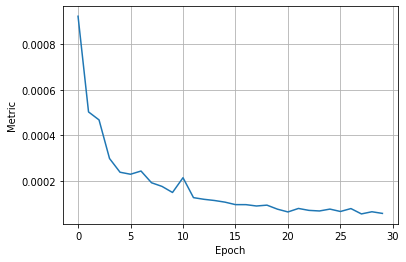

END OF EPOCH 29


In [53]:
compact_config = TaskConfig(
        gru_num_layers=2,
        hidden_size=13,
        cnn_out_channels=1,
        kernel_size=(3, 20),
        stride=(2, 8),
        num_epochs=30,
        learning_rate=1e-3,
)
SEED = 0
set_random_seed(SEED)

base_config = TaskConfig(hidden_size=32)
base_model = CRNN(base_config).to(TaskConfig.device)
base_model.load_state_dict(torch.load('base_model.pth'));

compact_model = CRNN(compact_config).to(TaskConfig.device)

print(compact_model)

opt = torch.optim.Adam(
    compact_model.parameters(),
    lr=compact_config.learning_rate,
    weight_decay=compact_config.weight_decay
)

scheduler = None


distil_coef = 0.9
conv_coef = 0.0
gru_coef = 0.0
temperature = 4


wandb.init(
    project='DLA-KWS',
    config={
    'Temperature' : temperature,
    'Distil Label Coef' : distil_coef,
    'Distil Conv Feature Coef' : conv_coef,
    'Distil Gru Feature Coef' : gru_coef,
    'architecture': 'Distillation GRU',
    **dataclasses.asdict(compact_config)
})


history = distillation_train(
        compact_model, base_model,  opt, scheduler,
        train_loader, val_loader, melspec_train, melspec_val, compact_config,
        distil_coef, conv_coef, gru_coef, temperature
)

In [54]:
torch.save(compact_model.state_dict(), 'compact_model.pth')

In [127]:
results['Distillation'] = (
      history['val_metric'][-1], calc_macs(compact_model), get_size_in_megabytes(compact_model)
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:951: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


### Training with Feature Distillation

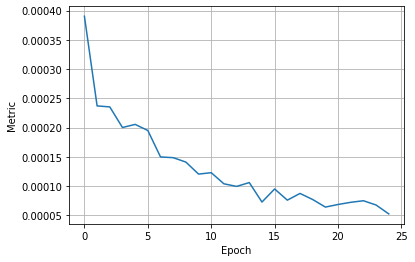

END OF EPOCH 24
TRAINING STOP: aquired target metric


In [51]:
compact_config = TaskConfig(
        gru_num_layers=2,
        hidden_size=13,
        cnn_out_channels=1,
        kernel_size=(3, 20),
        stride=(2, 8),
        num_epochs=30,
        learning_rate=1e-3,
)
SEED = 0
set_random_seed(SEED)

base_config = TaskConfig(hidden_size=32)
base_model = CRNN(base_config).to(TaskConfig.device)
base_model.load_state_dict(torch.load('base_model.pth'));

compact_model = CRNN(compact_config).to(TaskConfig.device)
# compact_model.gru = nn.RNN(144, 16, batch_first=True)

print(compact_model)

opt = torch.optim.Adam(
    compact_model.parameters(),
    lr=compact_config.learning_rate,
    weight_decay=compact_config.weight_decay
)

scheduler = None


distil_coef = 0.8
conv_coef = 0.1
gru_coef = 0.05
temperature = 4


wandb.init(
    project='DLA-KWS',
    config={
    'Temperature' : temperature,
    'Distil Label Coef' : distil_coef,
    'Distil Conv Feature Coef' : conv_coef,
    'Distil Gru Feature Coef' : gru_coef,
    'architecture': 'Feature Distillation GRU',
    **dataclasses.asdict(compact_config)
})


history = distillation_train(
        compact_model, base_model,  opt, scheduler,
        train_loader, val_loader, melspec_train, melspec_val, compact_config,
        distil_coef, conv_coef, gru_coef, temperature
)

In [52]:
torch.save(compact_model.state_dict(), 'feature_compact_model.pth')

In [82]:
compact_model = CRNN(compact_config).to(TaskConfig.device)
compact_model.load_state_dict(torch.load('feature_compact_model.pth'))

<All keys matched successfully>

In [69]:
results['Feature Distillation'] = (
      history['val_metric'][-1], calc_macs(compact_model), get_size_in_megabytes(compact_model)
)

In [70]:
results

{'Distillation': (5.754506132475677e-05, 90232.0, 0.015794754028320312),
 'Feature Distillation': (5.265e-05, 90232.0, 0.015794754028320312)}

In [ ]:
print('Compression rate:', get_size_in_megabytes(base_model) / get_size_in_megabytes(compact_model))
print('Speed-up rate:', calc_macs(base_model) / calc_macs(compact_model))

Compression rate: 8.27384805054708
Speed-up rate: 11.119130734057721


### FP16

In [182]:
fp16_compact_model = CRNN(compact_config).to(TaskConfig.device)
fp16_compact_model.load_state_dict(torch.load('feature_compact_model.pth'))

fp16_compact_model.change_type(torch.float16)

In [183]:
metric = validation(fp16_compact_model, val_loader, melspec_val, TaskConfig.device)[0]
macs = calc_macs(fp16_compact_model)
size = get_size_in_megabytes(fp16_compact_model)

results['Feature Distillation FP16'] = (metric, macs, size)

  0%|          | 0/102 [00:00<?, ?it/s]

In [184]:
print('Compression rate:', get_size_in_megabytes(base_model) / size)
print('Speed-up rate:', calc_macs(base_model) / macs)

Compression rate: 11.618262313226342
Speed-up rate: 10.02535685787747


### Plot Results

In [185]:
results

{'Distillation': (5.754506132475677e-05, 90232.0, 0.013743400573730469),
 'Feature Distillation': (5.265e-05, 90232.0, 0.015794754028320312),
 'Feature Distillation FP16': (5.268151004614256e-05,
  90232.0,
  0.008616447448730469),
 'Base model': (2.7814739275608353e-05, 904608.0, 0.10010814666748047)}

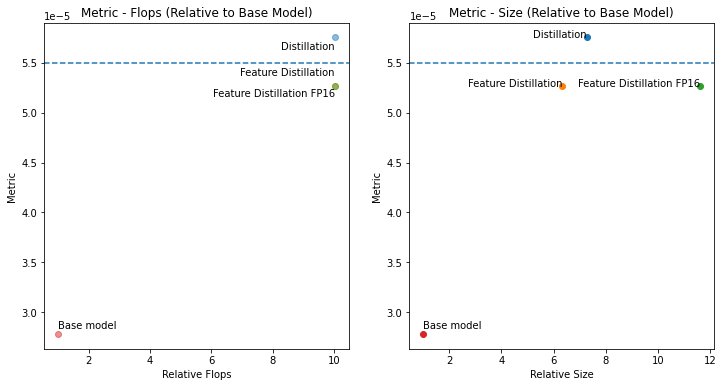

In [231]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

base_metric, base_macs, base_size = results['Base model']

for name, (metric, macs, size) in results.items():
  axs[0].scatter(base_macs / macs, metric, alpha=0.5)
  axs[1].scatter(base_size / size, metric)

  if name == 'Base model':
    axs[0].text(base_macs / macs, metric*1.02, name, horizontalalignment='left')
    axs[1].text(base_macs / macs, metric*1.02, name, horizontalalignment='left')
  elif name == 'Feature Distillation':
    axs[0].text(base_macs / macs, metric*1.02, name, horizontalalignment='right')
    axs[1].text(base_size / size, metric, name, horizontalalignment='right')
  else:
    axs[0].text(base_macs / macs, metric*0.98, name, horizontalalignment='right')
    axs[1].text(base_size / size, metric, name, horizontalalignment='right')


axs[0].axhline(1.1 * 5e-5, linestyle='--')
axs[1].axhline(1.1 * 5e-5, linestyle='--')

axs[0].set(xlabel='Relative Flops', ylabel='Metric', title='Metric - Flops (Relative to Base Model)')
axs[1].set(xlabel='Relative Size',  ylabel='Metric', title='Metric - Size (Relative to Base Model)');
plt.savefig('Final Comparison.pdf')

### GRU To RNN (Didn't work)

GRU requires several times more parameters and computations than RNN. RNN's weakness is vanishing gradients in long sequences. However in our case, we have 1-second audio tracks, which translates into approx. *sample_rate / (hop_size * stride[1])* $= 16000 / (160 * 8) \approx 13$ sequential embeddings for GRU. This means, that this optimization may work really well. Let's try it:

In [72]:
class GRUFreeCRNN(nn.Module):
    '''
      Similar to CRNN, but with RNN instead of GRU
    '''
    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.RNN(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        # used for layer distillation
        self.conv_out_size = self.conv_out_frequency * config.cnn_out_channels
        self.hidden_size = config.hidden_size

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input, return_features=False):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        # used for layer distillation
        if return_features:
          return conv_output, gru_output, output
        return output